In [1]:
import os
os.chdir('../../')


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import sin_data
from models import gaussian_mlp
from utilities import plot,fits,predict,gmm
from flax import linen as nn

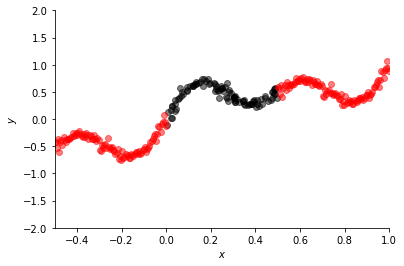

In [3]:
X,Y,x_test_1,y_test_1,x_test_2,y_test_2 = sin_data.load_data()
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

In [4]:
model = gaussian_mlp.gmlp( features=[16,16], activations=[nn.relu, nn.relu],dropout_rate=[0,0])

In [5]:
model.tabulate(jax.random.PRNGKey(1), X, deterministic=True)

                          gmlp Summary                          
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ outputs               ┃ params                 ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs      │ - float32[100,1]      │                        │
│             │ - deterministic: True │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ 0_Dense     │ float32[100,16]       │ bias: float32[16]      │
│             │                       │ kernel: float32[1,16]  │
│             │                       │                        │
│             │                       │ 32 (128 B)             │
├─────────────┼───────────────────────┼────────────────────────┤
│ 0_Dropout_0 │ float32[100,16]       │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ 1_Dense     │ float32[100,16]       │ bias: float32[16]      │
│             │                       │ kernel: float32[16,16] │
│             │                       │                        │
│             │                       │ 272 (1.1 KB)           │
├─────────────┼───────────────────────┼────────────────────────┤
│ 1_Dropout_0 │ float32[100,16]       │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│ Gaussian    │ float32[100,2]        │ bias: float32[2]       │
│             │                       │ kernel: float32[16,2]  │
│             │                       │                        │
│             │                       │ 34 (136 B)             │
├─────────────┼───────────────────────┼────────────────────────┤
│ gmlp        │ - float32[100]        │                        │
│             │ - float32[100]        │                        │
├─────────────┼───────────────────────┼────────────────────────┤
│             │                 Total │ 338 (1.4 KB)           │
└─────────────┴───────────────────────┴────────────────────────┘
                                                                
                 Total Parameters: 338 (1.4 KB)                 

'\n\n'

In [6]:
params_list = []
losses_list = []
auxs = {
    "X" : X,
    "y" : Y,
    "deterministic": True,
}

for i in range(5):
    params = model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fits.fit(model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)



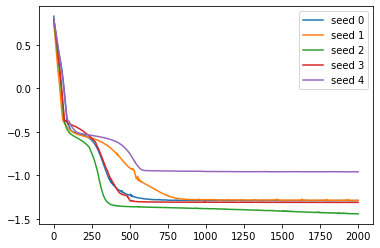

In [7]:
for i in range(5):
    plt.plot(jnp.arange(0,2000,1),losses_list[i],label='seed '+str(i))
plt.legend()

In [9]:
X  = jnp.sort(X[:,0]).reshape(100,1)
means_list,sigmas_list = predict.predict(5,model,params_list,X)
mean,sigma = predict.gmm_mean_var(means_list,sigmas_list)
mean_lx_list,sigma_lx_list = predict.predict(5,model,params_list,x_test_1)
mean_ux_list,sigma_ux_list = predict.predict(5,model,params_list,x_test_2)
mean_lx,sigma_lx = predict.gmm_mean_var(mean_lx_list,sigma_lx_list)
mean_ux,sigma_ux= predict.gmm_mean_var(mean_ux_list,sigma_ux_list)

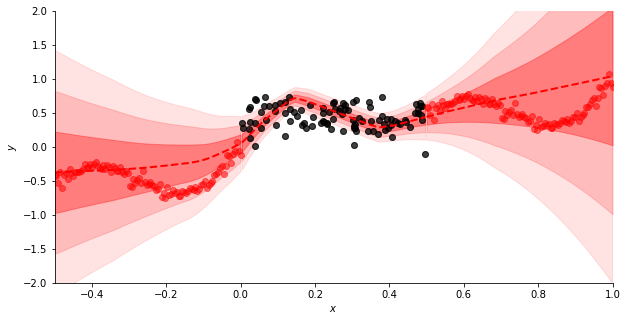

In [10]:
plt.figure(figsize=(10,5))
plt.plot(X,mean, "r--", linewidth=2)
plt.plot(x_test_1,mean_lx, "r--", linewidth=2)
plt.plot(x_test_2,mean_ux, "r--", linewidth=2)
for i_std in range(1,4):
  plt.fill_between(X.reshape(100), jnp.array((mean-i_std*sigma)), jnp.array((mean+i_std*sigma)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_1.reshape(100), jnp.array((mean_lx-i_std*sigma_lx)), jnp.array((mean_lx+i_std*sigma_lx)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_2.reshape(100), jnp.array((mean_ux-i_std*sigma_ux)), jnp.array((mean_ux+i_std*sigma_ux)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
plt.scatter(X, Y,color='black',alpha=0.5)
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

# plt.plot(X, final_mean+final_sigma)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2,2)
sns.despine()
plt.show()

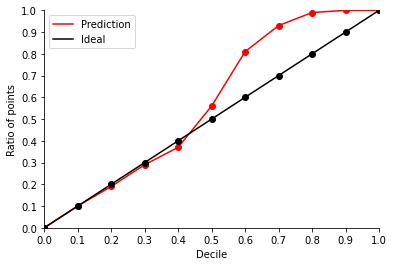

In [10]:
df = plot.calibration_regression(mean_ux,sigma_ux,y_test_2)


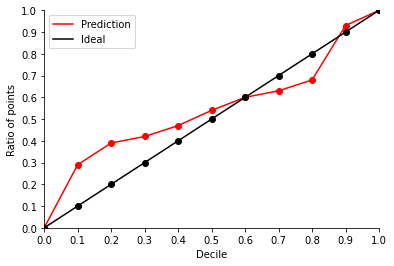

In [11]:
df = plot.calibration_regression(mean_lx,sigma_lx,y_test_1)




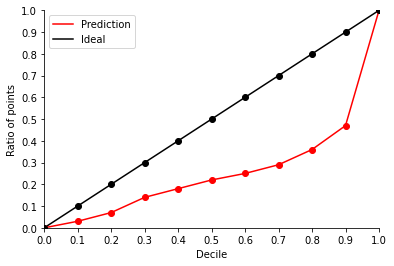

In [12]:
df = plot.calibration_regression(mean,sigma,Y)


In [13]:
seed=11
params = model.init(jax.random.PRNGKey(seed), X, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.003, epochs=2000, verbose=True)


Loss step 0:  0.7900317
Loss step 200:  -0.55616796
Loss step 400:  -1.1427149
Loss step 600:  -1.3426368
Loss step 800:  -1.3665277
Loss step 1000:  -1.3731878
Loss step 1200:  -1.3770965
Loss step 1400:  -1.3797836
Loss step 1600:  -1.3823776
Loss step 1800:  -1.3844365


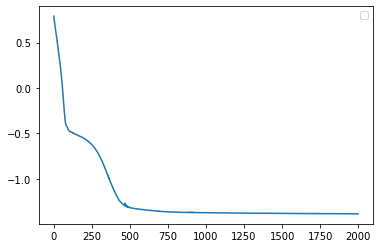

In [14]:
plt.plot(jnp.arange(0,2000,1),loss)
plt.legend()

In [15]:
X  = jnp.sort(X[:,0]).reshape(100,1)
mean,sigma = model.apply(params,X,deterministic=True)
mean_lx,sigma_lx = model.apply(params,x_test_1,deterministic=True)
mean_ux,sigma_ux = model.apply(params,x_test_2,deterministic=True)

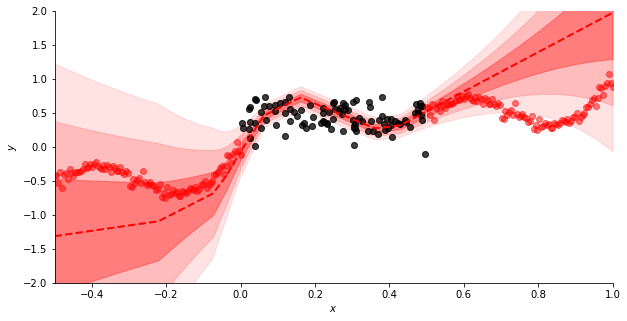

In [16]:
plt.figure(figsize=(10,5))
plt.plot(X,mean, "r--", linewidth=2)
plt.plot(x_test_1,mean_lx, "r--", linewidth=2)
plt.plot(x_test_2,mean_ux, "r--", linewidth=2)
for i_std in range(1,4):
  plt.fill_between(X.reshape(100), jnp.array((mean-i_std*sigma)), jnp.array((mean+i_std*sigma)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_1.reshape(100), jnp.array((mean_lx-i_std*sigma_lx)), jnp.array((mean_lx+i_std*sigma_lx)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_2.reshape(100), jnp.array((mean_ux-i_std*sigma_ux)), jnp.array((mean_ux+i_std*sigma_ux)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
plt.scatter(X, Y,color='black',alpha=0.5)
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

# plt.plot(X, final_mean+final_sigma)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2,2)
sns.despine()
plt.show()

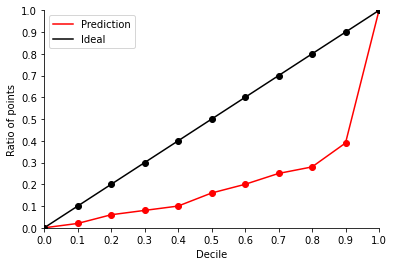

In [17]:
df = plot.calibration_regression(mean,sigma,Y)


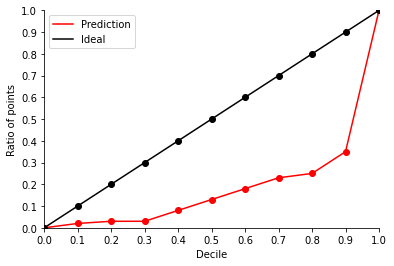

In [18]:
df = plot.calibration_regression(mean_ux,sigma_ux,y_test_2)

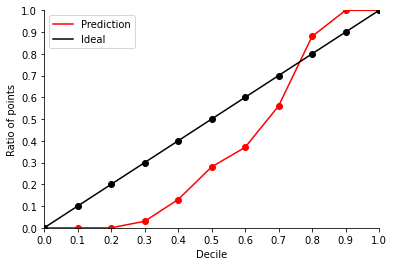

In [19]:
df = plot.calibration_regression(mean_lx,sigma_lx,y_test_1)